## Helpers

In [0]:
import os, sys, wave, struct

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy
from math import ceil
from scipy.io import wavfile, loadmat

# Needed imports
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile

def load_music(file):
    return wave.open(file, 'rb')

def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
def process_sound(music) :
    '''
    Process Sound
    '''
    wavefile = load_music(music)
    param = wavefile.getparams()

    Fs, data = wavfile.read(music)
    timestep = 1/float(Fs)
    times = np.arange(len(data))*timestep

    return Fs, data, times, param
  
def write_music_1D(file, param, data):
    '''
    Write Music in wav file (mono)
    '''
    wavefile = wave.open(file, 'wb')
    wavefile.setparams(param)
    wavefile.setnframes(len(data))
    wavefile.setnchannels(1)

    for i in range(len(data)):
        v = int(data[i])
        wavefile.writeframesraw( struct.pack('<h', v ) )
    wavefile.writeframes(''.encode())
    wavefile.close()

## 1. Extraction of the analysis marks

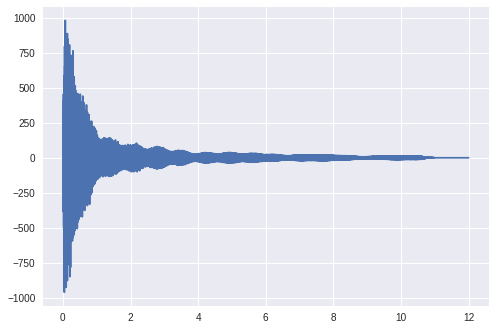

In [6]:
sound = 'ClocheA.WAV'
Fs, data, times, param = process_sound(sound)

plt.plot(times, data)
plt.show()

Audio(data,rate = Fs)

In [0]:
def nextpow2(x):
    assert x>0
    p = np.ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p

def period(x, Fs, Pmin=1/300., Pmax=1/80., seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = 1 + np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    Nfft = int(2**nextpow2(2*N-1))
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / float(N)
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/float(N-P))
    voiced = corr > seuil
    if not voiced :
        P = np.round(1e-2*Fs)

    return P,voiced

def AnalysispitchMarks(s,Fs):
  
  N = len(s)
  A = []
  
  ta = 1
  Pa = int(0.01*Fs)
  while ta + int(2.5*Pa) <N:
    #print(ta, ta + int(2.5*Pa), N)
    # extract sequence
    sequence = s[ta:ta + int(2.5*Pa) + 1]
    # compute Pa and voiced
    Pa, voiced = period(sequence, Fs)
    # compute ta
    ta += int(Pa) 
    A.append([ta,voiced,Pa])
    
  return np.array(A).T.reshape(3,-1).astype(int)

In [8]:
A = AnalysispitchMarks(data,Fs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


## 2. Synthesis and modification of the temporal and spectral scales

In [0]:
# Synthesis without modification
B = np.zeros((2,A.shape[1]))
B[0,:] = A[0,:]
B[1,:] = range(A.shape[1])
B = B.astype(int)

### 2.1. Signal synthesis

In [10]:
from scipy.signal import hann

def add_signal(y,a,b,x):
  
  if 0 <= a < b <= len(y):
    y[a,b] += x
  else:
    bounds = np.clip([a,b],0,len(y))
    y[bounds] += x[bounds] 
  return y

def Synthesis(s,A,B):
  
  ts = B[0,:]
  n = B[1,:]
  ta = A[0,:]
  Pa = A[2,:]
  k_end = len(ts) - 2
  
  y = np.zeros(ts[k_end] + Pa[n[k_end]])
  
  for k in range(k_end):
    ta_nk, Pa_nk = ta[n[k]], Pa[n[k]]
    # extract sequence
    sequence_x = s[ta_nk - Pa_nk:ta_nk + Pa_nk + 1]
    # Window x by hann
    windowed_x = sequence_x*hann(2*Pa_nk + 1)
    # add to y
    try:
      y[ts[k] - Pa_nk: ts[k] + Pa_nk + 1] += windowed_x
    except:
      pass
    
  return y
  
y = Synthesis(data,A,B)  

Audio(y,rate = Fs)

### 2.2. Modification of the temporal scale

In [11]:
def ChangeTimeScale(alpha,A):
  
  ts = [1]
  Pa = A[2,:]
  n = [0]
  
  for k in range(int(alpha*A.shape[1])-1):
    ts.append(ts[-1] + Pa[ int(np.floor(n[-1])) ] )
    n.append(n[-1] + 1./alpha)
    
  return np.array([ts,n]).astype(int)

#Try slow and fast

alpha = 2
B = ChangeTimeScale(alpha,A)

y_slow = list(Synthesis(data,A,B))  

alpha = 0.5
B = ChangeTimeScale(alpha,A)

y_fast = list(Synthesis(data,A,B))  

cut = 0.3

y = y_slow[:int(cut*len(y_slow))] + y_fast[int(cut*len(y_fast)):]

Audio(y,rate = Fs)

### 2.3. Modification of the spectral scale

In [12]:
def ChangePitchScale(beta,A):
  
  ts = [1]
  Pa = A[2,:]
  n = [0]
  scale = A[1,:]
  floor_nk = 0
  
  while floor_nk < len(Pa) - 1:
    
    floor_nk = int(np.floor(n[-1]))
    scale = 1 + (A[1,floor_nk] == 1)*(1./beta - 1)
    ts.append(ts[-1] + scale*Pa[ floor_nk ] )
    n.append(n[-1] + scale)
    
  return np.array([ts,n]).astype(int)

#Try it for a low voice and a high pitched voice

beta = 0.5
B = ChangePitchScale(beta,A)

y_low = list(Synthesis(data,A,B))

beta = 2
B = ChangePitchScale(beta,A)

y_high = list(Synthesis(data,A,B))

cut = 0.56

y = y_low[:int(cut*len(y_low))] + y_high[int(cut*len(y_high)):]

Audio(y,rate = Fs)

### 2.4. Joint modification of the temporal and spectral scales

In [0]:
def ChangeBoth(alpha,beta,A):
  
  ts = [1]
  Pa = A[2,:]
  n = [0]
  scale = A[1,:]
  
  while int(np.floor(n[-1])) < len(Pa):
    
    floor_nk = int(np.floor(n[-1]))
    scale = 1 + (A[1,floor_nk] == 1)*(1/(beta) - 1)
    ts.append(ts[-1] + scale*Pa[ floor_nk ] )
    n.append(n[-1] + scale/alpha)  #rescale n to make it longer or shorter
    
    
  return np.array([ts,n]).astype(int)

In [14]:
alpha = 0.5
beta = 0.5
B = ChangeBoth(alpha,beta,A)

y = list(Synthesis(data,A,B)) 

Audio(y,rate = Fs)